In [1]:
%pip install pandas matplotlib mysqlclient sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

TABLE = "hk_immigration_sum_daily"
database_url = 'sqlite:///../data/data.sqlite'

# 创建数据库引擎
engine = create_engine(database_url)

In [3]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 准备数据
queryAll = f"SELECT * FROM {TABLE} WHERE 日期 >= '2020-05-01' AND 日期 <= '2020-12-31';"
dfAll = pd.read_sql_query(queryAll, engine)

query2020 = f"SELECT * FROM {TABLE} WHERE 日期 >= '2020-05-01' AND 日期 <= '2020-12-31';"
df2020 = pd.read_sql_query(query2020, engine)

query2021 = f"SELECT * FROM {TABLE} WHERE 日期 >= '2021-01-01' AND 日期 <= '2021-12-31';"
df2021 = pd.read_sql_query(query2021, engine)

query2022 = f"SELECT * FROM {TABLE} WHERE 日期 >= '2022-01-01' AND 日期 <= '2022-12-31';"
df2022 = pd.read_sql_query(query2022, engine)

query2023 = f"SELECT * FROM {TABLE} WHERE 日期 >= '2023-01-01' AND 日期 <= '2023-12-31';"
df2023 = pd.read_sql_query(query2023, engine)

# 创建归一化器实例
scaler = MinMaxScaler()


# 定义一个函数来归一化除了日期外的所有列
def normalize_df(df):
    date_column = df['日期']
    df_scaled = pd.DataFrame(scaler.fit_transform(df.drop('日期', axis=1)), columns=df.columns[1:])
    df_scaled['日期'] = date_column
    return df_scaled


# 归一化数据
dfAll_normalized = normalize_df(dfAll)
df2020_normalized = normalize_df(df2020)
df2021_normalized = normalize_df(df2021)
df2022_normalized = normalize_df(df2022)
df2023_normalized = normalize_df(df2023)

In [4]:
from matplotlib import font_manager

# fname中选择一个你本机查询出来的字体 若没有中文字体则需要你本人手动安装
plt.rc("font", family='MicroSoft YaHei', weight="bold")
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

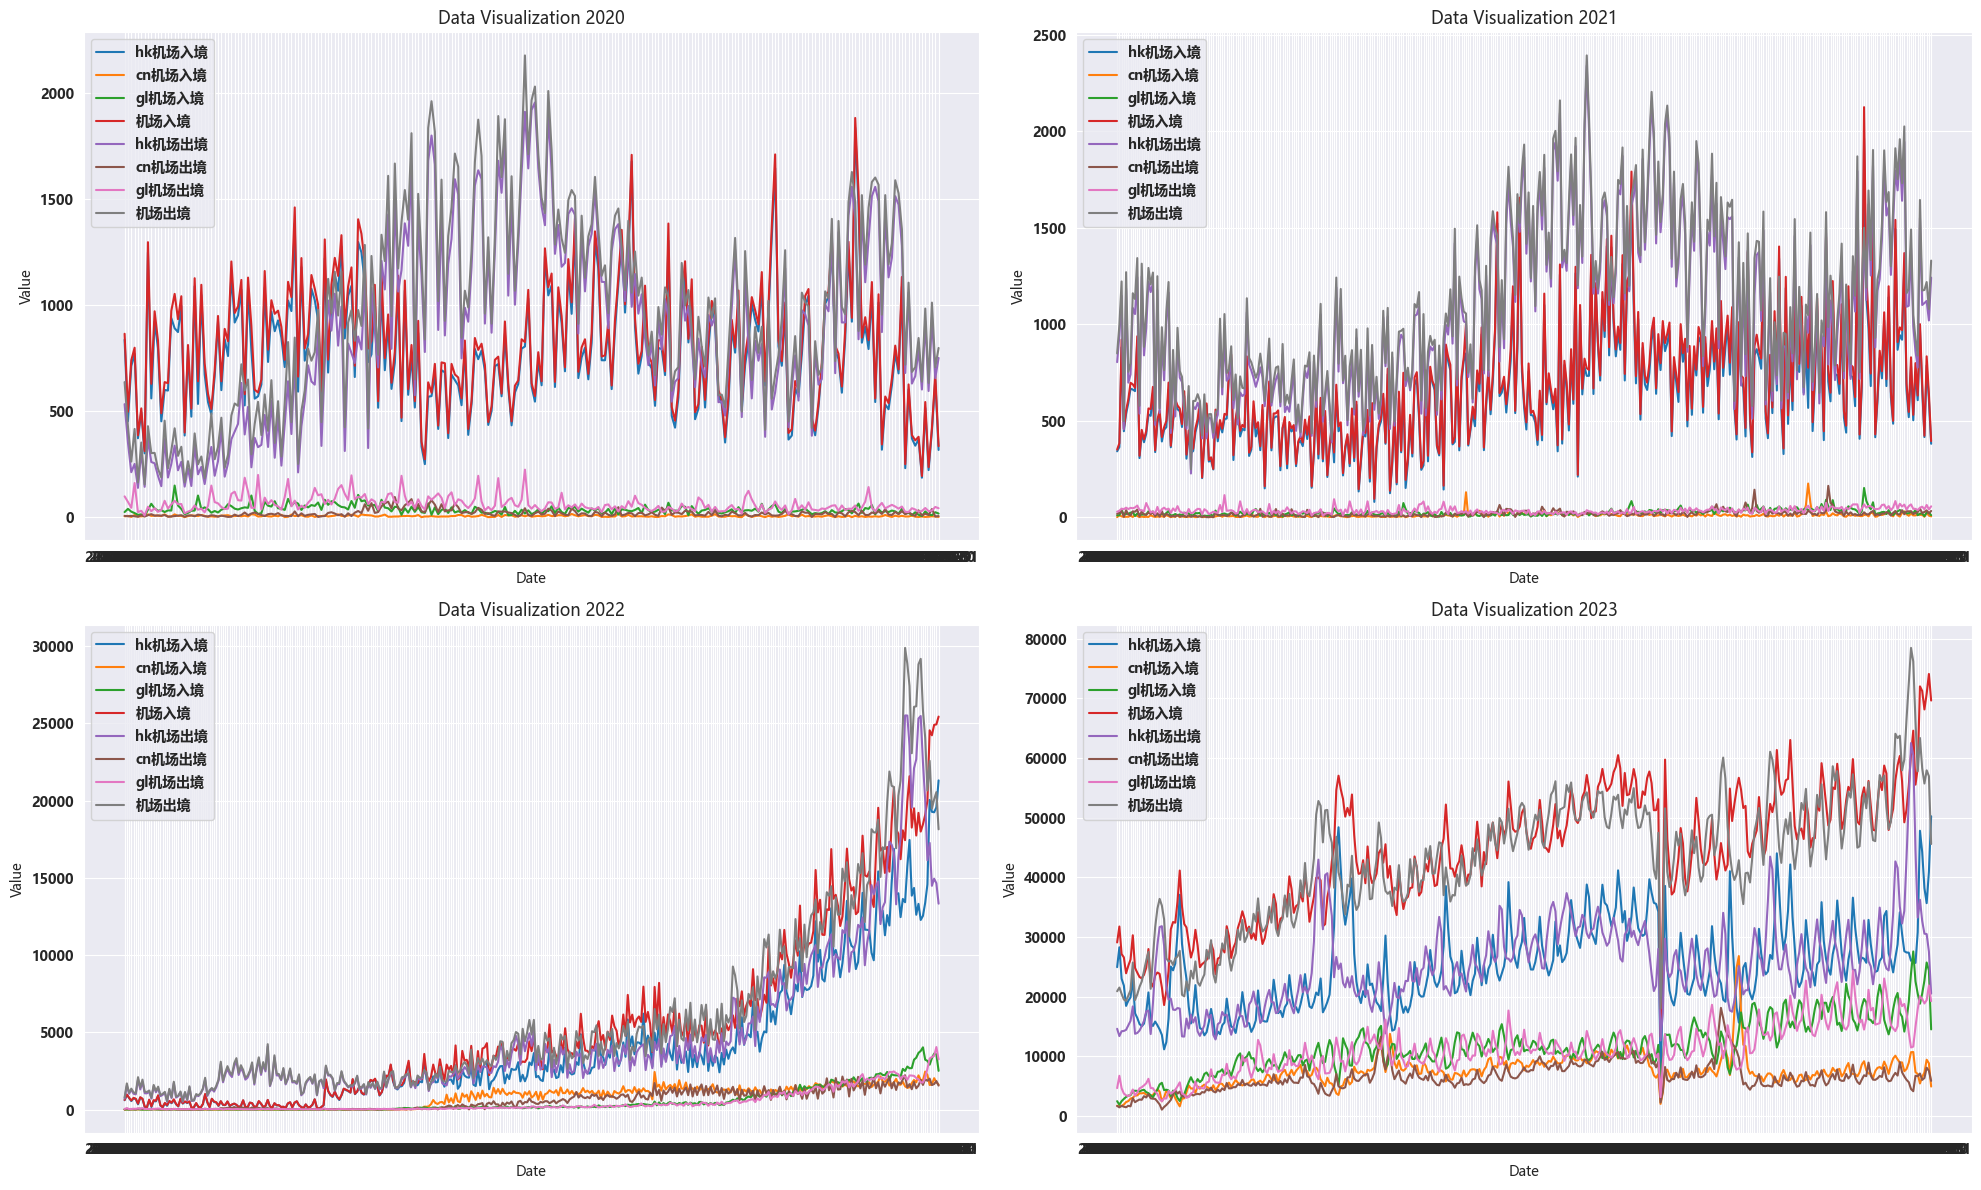

In [5]:
import matplotlib.pyplot as plt

# 设置图形大小并创建一个 2x2 的图表布局
fig, axs = plt.subplots(2, 2, figsize=(20, 12))


# 定义一个小函数来简化代码
def plot_data(ax, df, title):
    for column in df.columns:
        if column != '日期':
            ax.plot(df['日期'], df[column], label=column)
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_title(title)


# 分别绘制每年的数据
plot_data(axs[0, 0], df2020, 'Data Visualization 2020')
plot_data(axs[0, 1], df2021, 'Data Visualization 2021')
plot_data(axs[1, 0], df2022, 'Data Visualization 2022')
plot_data(axs[1, 1], df2023, 'Data Visualization 2023')

# 调整子图间距
plt.tight_layout()
plt.show()


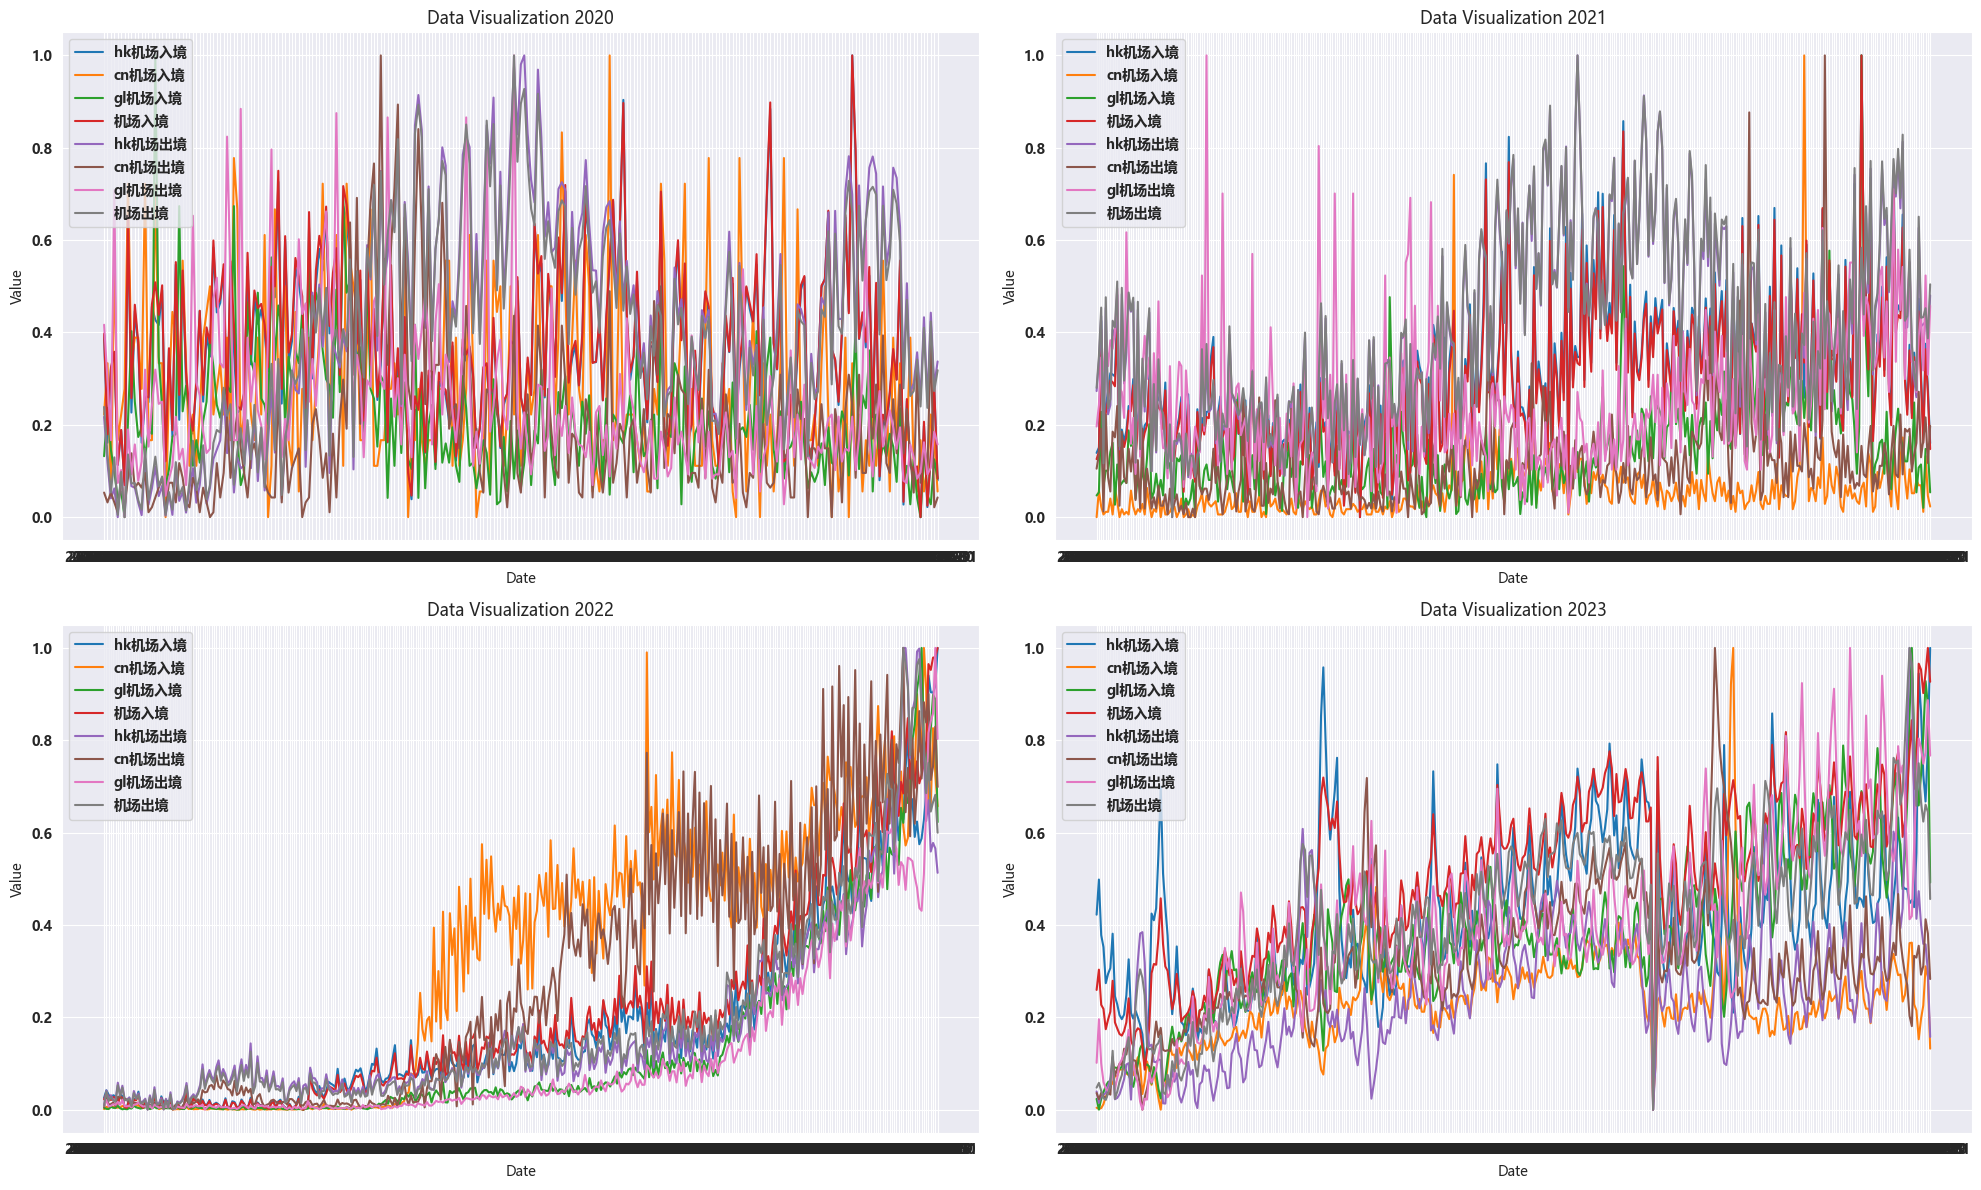

In [6]:
# 绘图代码，使用归一化后的数据
fig, axs = plt.subplots(2, 2, figsize=(20, 12))


# 定义一个小函数来简化代码
def plot_data(ax, df, title):
    for column in df.columns:
        if column != '日期':
            ax.plot(df['日期'], df[column], label=column)
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_title(title)


# 分别绘制每年的数据
plot_data(axs[0, 0], df2020_normalized, 'Data Visualization 2020')
plot_data(axs[0, 1], df2021_normalized, 'Data Visualization 2021')
plot_data(axs[1, 0], df2022_normalized, 'Data Visualization 2022')
plot_data(axs[1, 1], df2023_normalized, 'Data Visualization 2023')

# 调整子图间距
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
import pandas as pd
from dtaidistance import dtw
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# 假设 df 是你的DataFrame，并且所有列都是数值型数据
def matrix_plt(mat: pd.DataFrame, title="DTW Distance Matrix"):
    # 使用Seaborn绘制热图
    plt.rc("font", family='MicroSoft YaHei', weight="bold")
    plt.figure(figsize=(10, 8))
    sns.heatmap(mat, annot=True, cmap="viridis")
    plt.title(title)
    plt.show()


# dtw的绝对值没有意义，但是相对值有意义，所以进行归一化
def dtw_matrix(df: pd.DataFrame):
    tmp_scaler = MinMaxScaler()
    for column in df.columns:
        if column == '日期':
            df = df.drop(columns=['日期'])
    # 创建一个空的DataFrame用于存储DTW距离
    series = df.values.astype(np.float64).swapaxes(1, 0)
    mat = dtw.distance_matrix_fast(series)
    # 对角线填充为0
    np.fill_diagonal(mat, 0)
    dtw_matrix_log = tmp_scaler.fit_transform(mat)
    # 加上column name
    dtw_matrix_frame = pd.DataFrame(data=dtw_matrix_log, columns=df.columns, index=df.columns)
    return dtw_matrix_frame

# 3. 日度数据关联程度

(由于总计出入境，总计出境，总计入境与其他数据关联太小，从数据库中删除，不做分析）

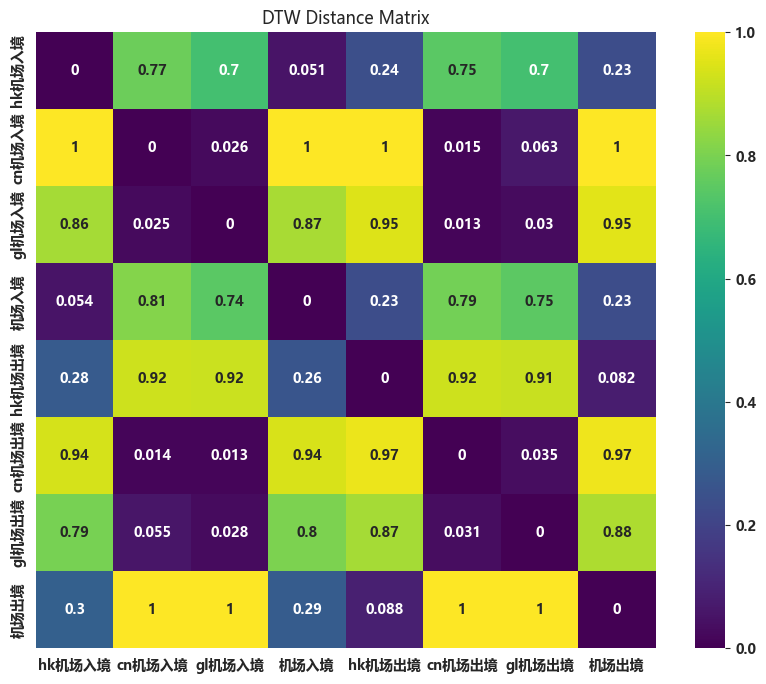

In [8]:
matrix_plt(dtw_matrix(dfAll))

从图中可以看出，我们把外国人香港机场入境（gl机场入境）设为baseline
可以发现和其关系最近的为cn机场出境入境，次深的为gl机场出境。
距离分别为200-300左右，其他的例如和gl机场出境的距离有1000

# 4. 月度数据关联程度
## 3.1 全月度

In [9]:
# 取出 < 2023-12 的hk月度数据
queryHkMonthly = "select * from hk_immigration_sum_monthly where 日期<'2024-01-01'"
dfHkMonthly = pd.read_sql_query(queryHkMonthly, engine)

# 取出 2019.4~2023.12的sh月度数据
queryShMonthly = "select * from sh_immigration where 日期<'2024-01-01' and 日期>='2019-04-01'"
dfShMonthly = pd.read_sql_query(queryShMonthly, engine)

dfMonthly = pd.merge(dfHkMonthly, dfShMonthly, how='inner').drop(columns=['日期'])

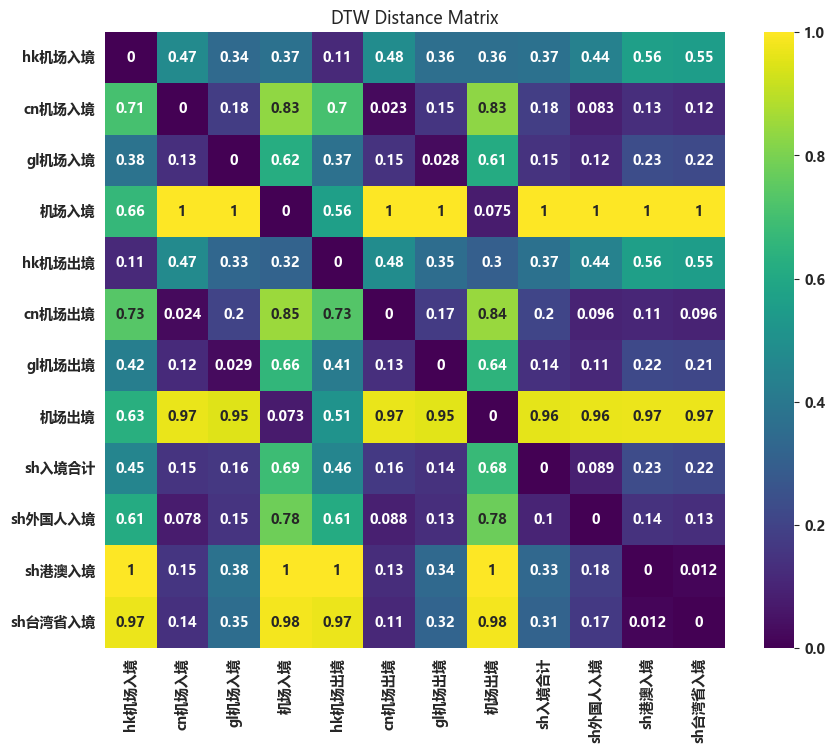

In [10]:
matrix_plt(dtw_matrix(dfMonthly))

## 3.2 2023年月度（后疫情时代）

In [11]:
# 取出 < 2023-12 的hk月度数据
queryHkMonthly2023 = "select * from hk_immigration_sum_monthly where 日期<'2024-01-01' and 日期>='2023-01-01'"
dfHkMonthly2023 = pd.read_sql_query(queryHkMonthly2023, engine)

# 取出 2019.4~2023.12的sh月度数据
queryShMonthly2023 = "select * from sh_immigration where 日期<'2024-01-01' and 日期>='2023-01-01'"
dfShMonthly2023 = pd.read_sql_query(queryShMonthly2023, engine)

dfMonthly2023 = pd.merge(dfHkMonthly2023, dfShMonthly2023, how='inner').drop(columns=['日期'])

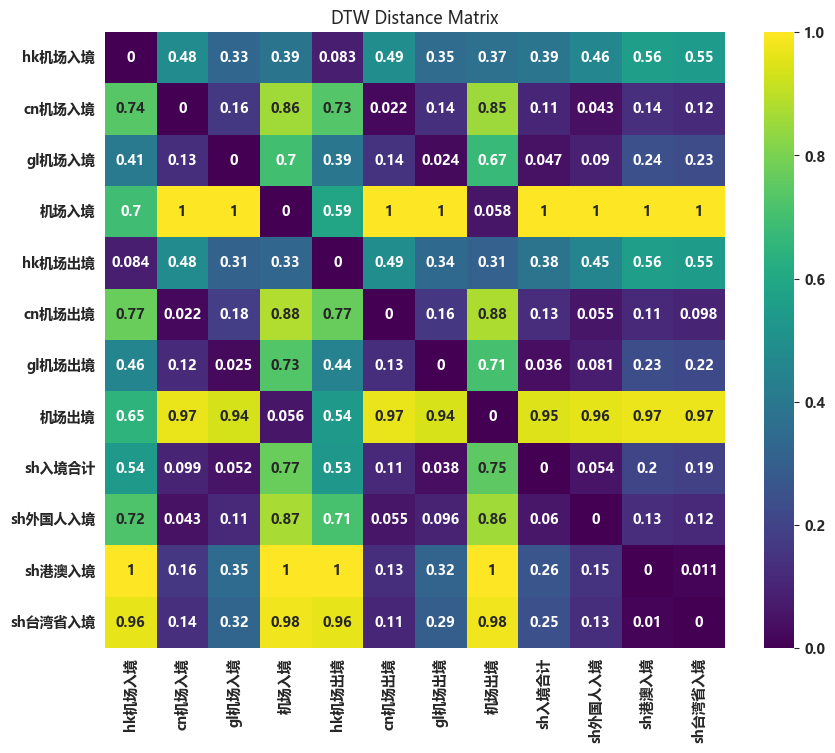

In [12]:
matrix_plt(dtw_matrix(dfMonthly2023))

# 3.3 2020年月度（疫情时间）

In [13]:
queryHkMonthly2020 = "select * from hk_immigration_sum_monthly where 日期<'2021-01-01' and 日期>='2020-01-01'"
dfHkMonthly2020 = pd.read_sql_query(queryHkMonthly2020, engine)

queryShMonthly2020 = "select * from sh_immigration where 日期<'2021-01-01' and 日期>='2020-01-01'"
dfShMonthly2020 = pd.read_sql_query(queryShMonthly2020, engine)

dfMonthly2020 = pd.merge(dfHkMonthly2020, dfShMonthly2020, how='inner').drop(columns=['日期'])

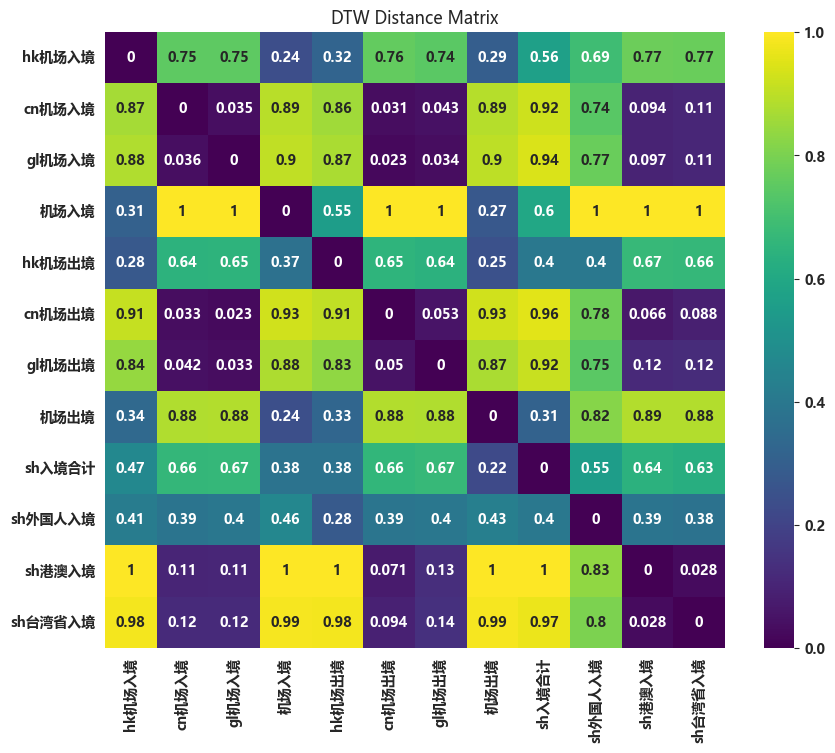

In [14]:
matrix_plt(dtw_matrix(dfMonthly2020))

# 3.4 差异比较

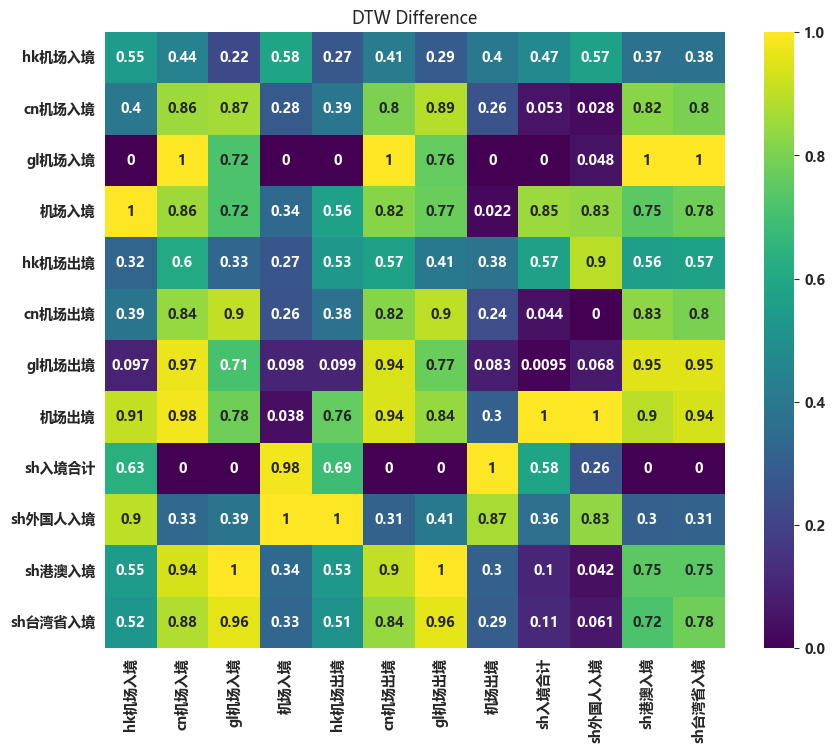

In [15]:
# 这一步为了避免两边数值大小的影响，这里不看数值绝对值只看偏离值
diff = dtw_matrix(dfMonthly2023) - dtw_matrix(dfMonthly2020)
# 这一步为了将数值缩放到合理的区间
diff = pd.DataFrame(data=scaler.fit_transform(diff), columns=dfMonthly2023.columns, index=dfMonthly2023.columns)
matrix_plt(diff, "DTW Difference")

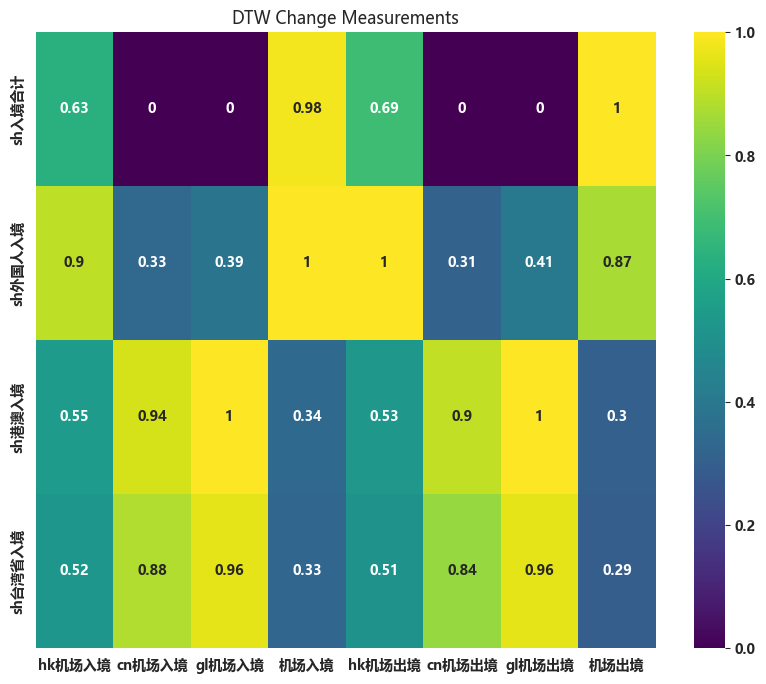

In [16]:
# 找出总变动最少的列
# 行中只保留sh相关，列中只保留hk相关
diff_sum = diff.drop(columns=dfShMonthly.drop(columns=['日期']).columns,
                     index=dfHkMonthly.drop(columns=['日期']).columns)

matrix_plt(diff_sum, "DTW Change Measurements")

# 3.5 结论

1. 在疫情期间，最接近的列为：cn，gl的机场出入境
2. 在非疫情期间，最接近的列为：cn,gl的机场出入境
3. 在差异比较中，变化最小的是cn机场入境，其次是cn和gl出境以及gl入境
4. 综上所述，对于数据的每日估计，使用cn和gl出入境数据为主来预测是可行的，原因如下
5. 第一，在疫情期间和疫情前后数据关联差异并不大，所以不需分两个模型预测
6. 第二，对于sh表中的四条数据，选择的hk表中的四条数据的关联各有千秋，使用四种数据的综合数据辅以模型预测想必是没有问题的

# 3.6 实施方案

1. 疫情期间数据与其他数据不分开处理
2. 将所有的数据转换为比率（日比月比率）
3. 每一项一定比例参与对baseline的贡献

# 4 取数据

In [36]:
from sklearn.preprocessing import MinMaxScaler

# 选取baseline
groups = ['gl机场入境', 'gl机场出境', 'cn机场入境', 'cn机场出境']
contrib = [1, 1, 1, 1]  # equal contribution

querySelected = "select * from hk_immigration_selected where 日期>='2023-01-01';"
dfSelected = pd.read_sql(querySelected, engine)

# minmax_scaler = MinMaxScaler()
# for col in dfSelected.columns:
#     if col != '日期':
#         dfSelected[col] = minmax_scaler.fit_transform(dfSelected[col].values.reshape(-1, 1))
# 
# mat = dfSelected.drop(columns=['日期']).values
# dfSelected['trend'] = minmax_scaler.inverse_transform(np.average(mat, axis=1, weights=contrib).reshape(-1,1))

# 写入数据库
# dfSelected.drop(columns=groups).to_sql('hk_pred_trend', con=engine, if_exists='replace', index=True)

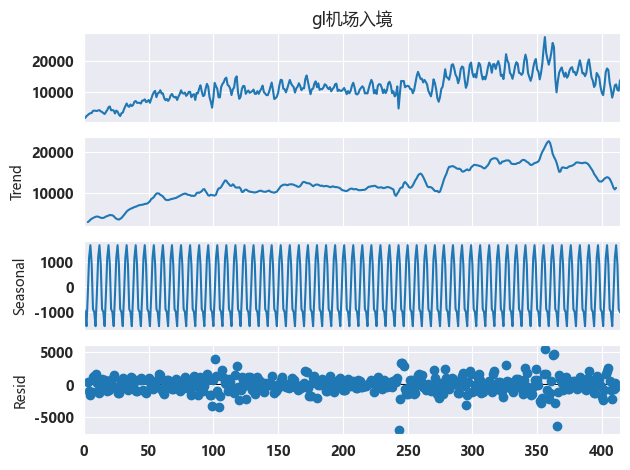

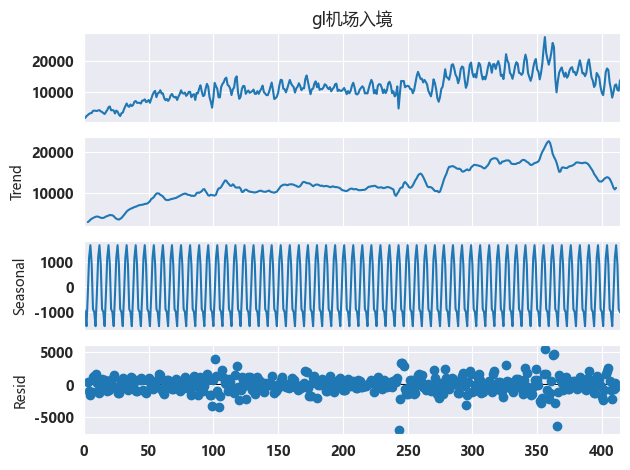

In [40]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(dfSelected['gl机场入境'] ,model='addictive', period=7)
decomposition.plot()


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

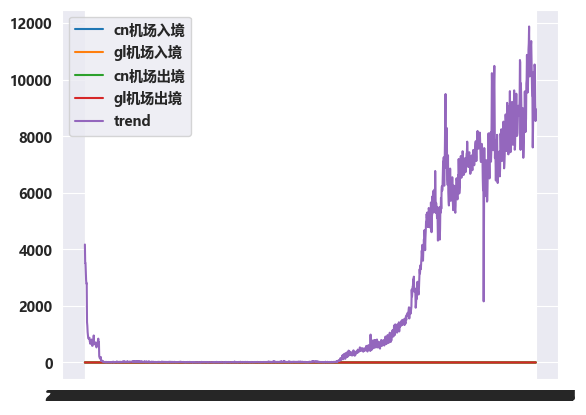

In [19]:
plot_data(plt, dfSelected, "trend")